In [15]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

# Step 2: Load the dataset
df = pd.read_csv("UberDataset.csv")

# Step 3: Inspect first few rows
df.head()


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [16]:
# Check column names in dataset
print(df.columns)


Index(['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES',
       'PURPOSE'],
      dtype='object')


In [17]:
# Convert datetime columns
df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], errors='coerce')

# Drop rows with missing start date
df = df.dropna(subset=['START_DATE'])
df.head()


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [18]:
# Extract useful time features
df['hour'] = df['START_DATE'].dt.hour
df['day_of_week'] = df['START_DATE'].dt.dayofweek   # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df[['START_DATE', 'hour', 'day_of_week', 'is_weekend']].head()


,START_DATE,hour,day_of_week,is_weekend
0,2016-01-01 21:11:00,21,4,0
1,2016-01-02 01:25:00,1,5,1
2,2016-01-02 20:25:00,20,5,1
3,2016-01-05 17:31:00,17,1,0
4,2016-01-06 14:42:00,14,2,0


In [19]:
# Group by pickup zone (START location) and hour
demand = df.groupby(['START', 'hour']).size().reset_index(name='ride_count')

# Show demand counts for each zone
demand.head()


,START,hour,ride_count
0,Agnew,8,1
1,Agnew,10,1
2,Agnew,19,1
3,Agnew,21,1
4,Apex,13,2


In [20]:
# Example: Top pickup zones at 8 PM
demand[demand['hour'] == 20].sort_values('ride_count', ascending=False).head()



,START,hour,ride_count
38,Cary,20,10
147,Morrisville,20,9
79,Financial District,20,1
85,Fort Pierce,20,1
124,Mcvan,20,1


In [21]:
def recommend_zones(hour, top_n=3):
    """
    Recommend top pickup zones (START locations) for a given hour.
    """
    subset = demand[demand['hour'] == hour].sort_values('ride_count', ascending=False)
    return subset.head(top_n)

# Example: Best zones at 6 PM
recommend_zones(18, top_n=5)


,START,hour,ride_count
36,Cary,18,11
253,Whitebridge,18,3
221,Unknown Location,18,3
7,Apex,18,2
97,Islamabad,18,2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


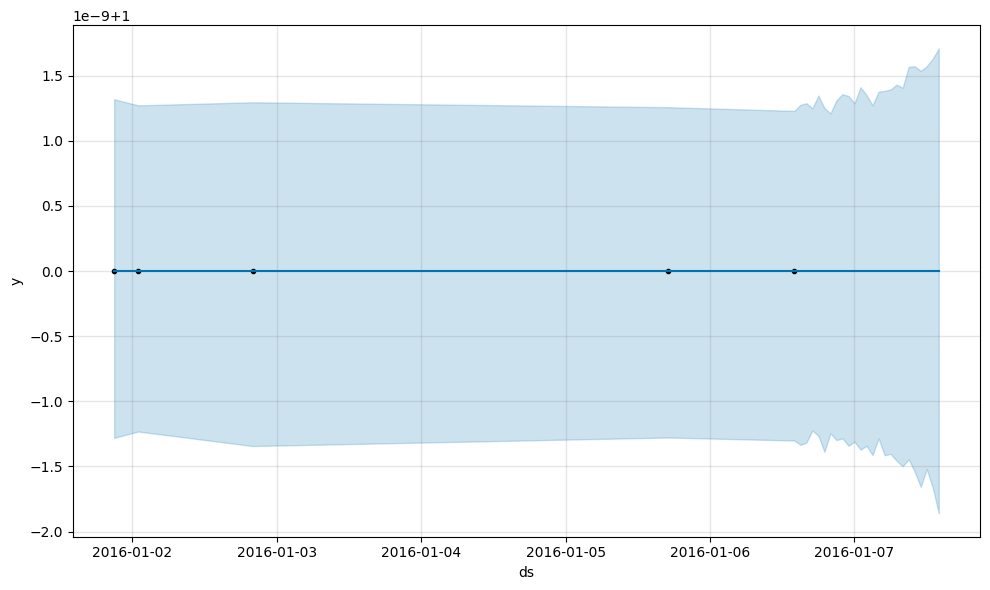

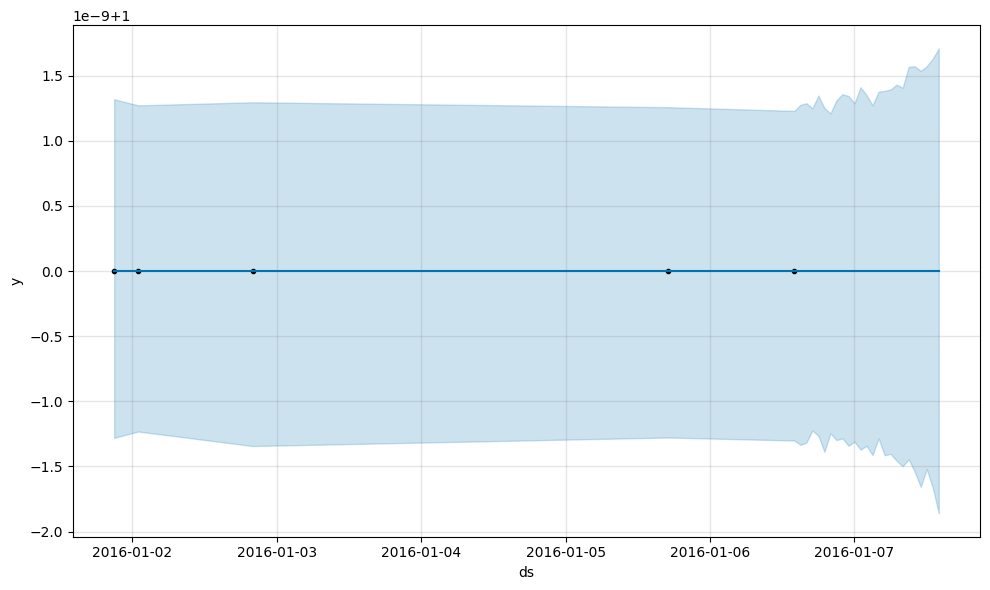

In [22]:
# Install Prophet (only once in Colab)
!pip install prophet

# Import again after installation
from prophet import Prophet

# Choose a zone from your dataset
zone = df['START'].dropna().unique()[0]  # first valid zone

# Aggregate rides per hour for this zone
ts = (
    df[df['START'] == zone]
    .groupby(df['START_DATE'].dt.floor('h'))  # use 'h' instead of 'H'
    .size()
    .reset_index(name='ride_count')
)

ts = ts.rename(columns={'START_DATE': 'ds', 'ride_count': 'y'})

# Train Prophet model
model = Prophet()
model.fit(ts)

# Forecast next 24 hours
future = model.make_future_dataframe(periods=24, freq='h')  # lowercase 'h'
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)


In [23]:
def forecast_zone(zone, periods=24):
    """
    Forecast demand for a single pickup zone using Prophet.
    """
    ts = df[df['START'] == zone].groupby(df['START_DATE'].dt.floor('H')).size().reset_index(name='ride_count')
    ts = ts.rename(columns={'START_DATE': 'ds', 'ride_count': 'y'})

    if len(ts) < 10:  # not enough data to forecast
        return None

    model = Prophet()
    model.fit(ts)
    future = model.make_future_dataframe(periods=periods, freq='H')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']]


In [24]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

def forecast_rides(df, zones, periods=24):
    results = {}

    for zone in zones:
        # Filter and aggregate hourly rides
        ts = (
            df[df['START'] == zone]
            .groupby(df['START_DATE'].dt.floor('h'))
            .size()
            .reset_index(name='ride_count')
        )
        ts.columns = ['ds', 'y']  # Prophet requires columns ds (date) and y (value)

        if ts.empty:
            print(f"No data available for zone {zone}, skipping...")
            continue

        # Adjust n_changepoints if dataset is small
        n_changepoints = min(25, max(1, len(ts) // 2))

        # Build and fit the model
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,
            n_changepoints=n_changepoints
        )
        model.fit(ts)

        # Forecast future rides
        future = model.make_future_dataframe(periods=periods, freq='h')
        forecast = model.predict(future)

        # Save forecast
        results[zone] = forecast

        # Plot
        fig = model.plot(forecast)
        plt.title(f"Forecast for {zone}")
        plt.xlabel("Date")
        plt.ylabel("Ride Count")
        plt.show()

    return results


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_zone(df, zone, test_days=7):
    """
    Train on all but last N days, test on last N days.
    Returns MAE, RMSE, and comparison DataFrame.
    """
    ts = (
        df[df['START'] == zone]
        .groupby(df['START_DATE'].dt.floor('h'))
        .size()
        .reset_index(name='ride_count')
    )
    ts.columns = ['ds', 'y']

    if len(ts) < test_days * 24:
        return None  # Not enough data

    # Split
    train = ts.iloc[:-test_days*24]
    test = ts.iloc[-test_days*24:]

    # Train Prophet
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(train)

    # Forecast test period
    future = model.make_future_dataframe(periods=len(test), freq='h')
    forecast = model.predict(future)

    # Merge with test set
    compare = test.merge(forecast[['ds','yhat']], on='ds', how='left')

    # Metrics
    mae = mean_absolute_error(compare['y'], compare['yhat'])
    rmse = mean_squared_error(compare['y'], compare['yhat'], squared=False)

    return mae, rmse, compare


In [27]:
zones = df['START'].dropna().unique()
results = {}

for zone in zones[:5]:  # test first 5 zones (can increase)
    evaluation = evaluate_zone(df, zone, test_days=7)
    if evaluation:
        mae, rmse, compare = evaluation
        results[zone] = (mae, rmse)
        print(f"Zone: {zone} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")


In [34]:
def evaluate_zone(df, zone, test_days=3):
    # Build time series
    ts = (
        df[df['START'] == zone]
        .groupby(df['START_DATE'].dt.floor('h'))
        .size()
        .reset_index(name='ride_count')
    )
    ts.columns = ['ds', 'y']

    if ts.empty:
        print(f"No data for {zone}, skipping...")
        return None

    # 🔹 Reindex to continuous hourly series
    full_range = pd.date_range(start=ts['ds'].min(), end=ts['ds'].max(), freq='h')
    ts = ts.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    ts.columns = ['ds', 'y']

    if len(ts) < test_days * 24:
        print(f"Not enough data for {zone}, skipping...")
        return None

    # Train-test split
    train = ts.iloc[:-test_days*24]
    test = ts.iloc[-test_days*24:]

    # Train Prophet
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(train)

    # Forecast
    future = model.make_future_dataframe(periods=test_days*24, freq='h')
    forecast = model.predict(future)

    # Merge forecast with actual test
    compare = forecast[['ds', 'yhat']].merge(test, on='ds', how='left')

    # 🔹 Drop rows where test 'y' is NaN
    compare = compare.dropna(subset=['y'])

    if compare.empty:
        print(f"No valid comparison data for {zone}, skipping...")
        return None

    # Compute errors
    mae = mean_absolute_error(compare['y'], compare['yhat'])
    rmse = np.sqrt(mean_squared_error(compare['y'], compare['yhat']))

    return mae, rmse, compare


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl9eun9zt/aqjvugms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl9eun9zt/u5wb568t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91954', 'data', 'file=/tmp/tmpl9eun9zt/aqjvugms.json', 'init=/tmp/tmpl9eun9zt/u5wb568t.json', 'output', 'file=/tmp/tmpl9eun9zt/prophet_modele223q4oz/prophet_model-20250913072059.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


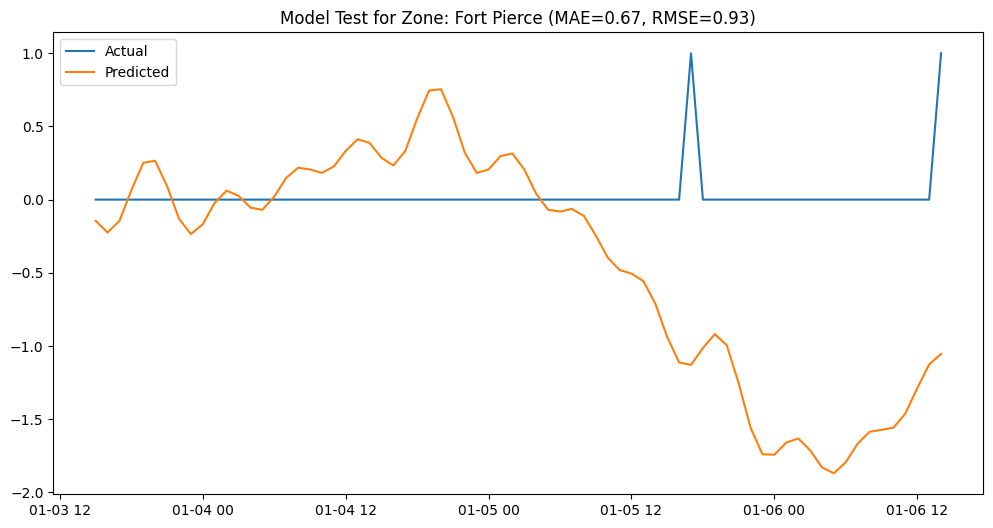

In [35]:
# Try zones until one works
for z in zones:
    evaluation = evaluate_zone(df, z, test_days=3)
    if evaluation:
        mae, rmse, compare = evaluation
        zone = z
        break

plt.figure(figsize=(12,6))
plt.plot(compare['ds'], compare['y'], label="Actual")
plt.plot(compare['ds'], compare['yhat'], label="Predicted")
plt.legend()
plt.title(f"Model Test for Zone: {zone} (MAE={mae:.2f}, RMSE={rmse:.2f})")
plt.show()


In [36]:
def recommend_future_zones(df, hours_ahead=3, top_n=3):
    """
    Recommend top pickup zones based on forecasted demand.
    """
    future_demand = []

    for zone in df['START'].dropna().unique():
        ts = (
            df[df['START'] == zone]
            .groupby(df['START_DATE'].dt.floor('h'))
            .size()
            .reset_index(name='ride_count')
        )
        ts.columns = ['ds', 'y']
        if len(ts) < 10:
            continue

        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(ts)

        future = model.make_future_dataframe(periods=hours_ahead, freq='h')
        forecast = model.predict(future)

        predicted = forecast.iloc[-1]['yhat']
        future_demand.append((zone, predicted))

    return sorted(future_demand, key=lambda x: x[1], reverse=True)[:top_n]

# Example: Best zones 3 hours from now
recommend_future_zones(df, hours_ahead=3, top_n=5)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl9eun9zt/9sys8k0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl9eun9zt/jeedkykk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57451', 'data', 'file=/tmp/tmpl9eun9zt/9sys8k0h.json', 'init=/tmp/tmpl9eun9zt/jeedkykk.json', 'output', 'file=/tmp/tmpl9eun9zt/prophet_model0cyth38w/prophet_model-20250913072203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/

[('Cary', np.float64(1.085913203275499)),
 ('Durham', np.float64(1.0)),
 ('Raleigh', np.float64(1.0)),
 ('Unknown Location', np.float64(1.0)),
 ('Morrisville', np.float64(0.9217833119245445))]

/tmp/ipython-input-3111245142.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_hotspots_per_hour = hotspot_df.groupby('hour').apply(lambda x: x.nlargest(5, 'ride_count')).reset_index(drop=True)


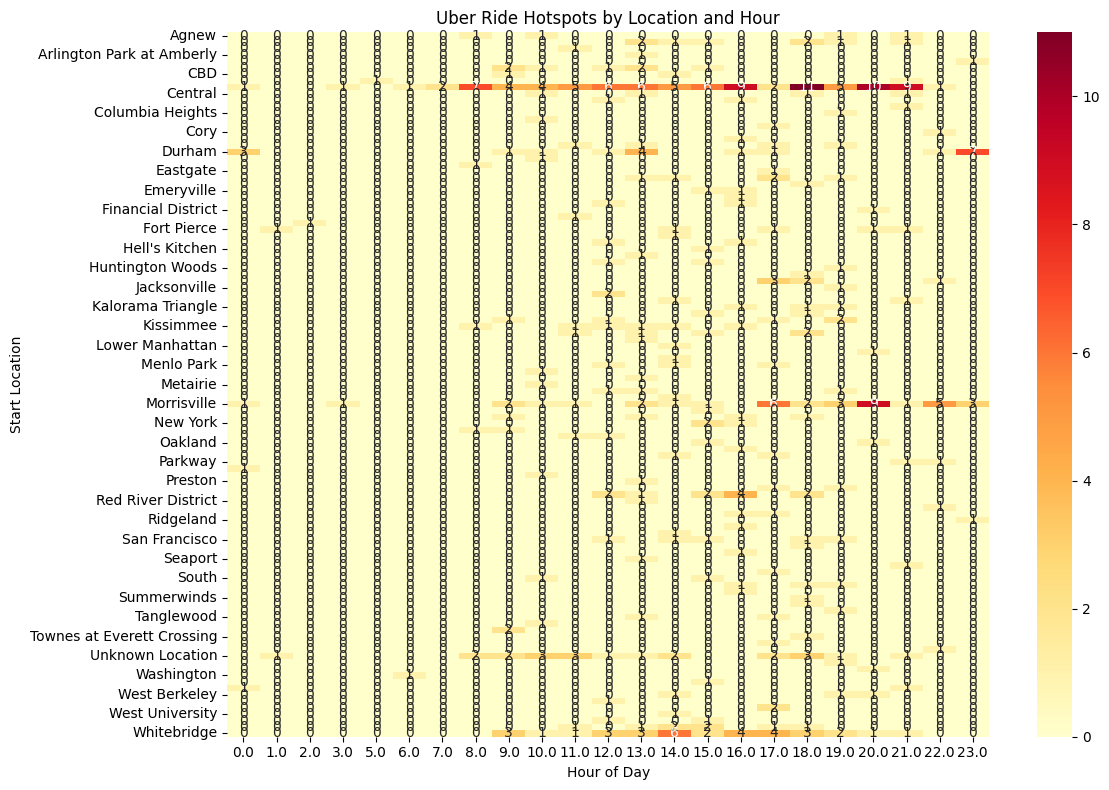

<Figure size 640x480 with 0 Axes>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (replace with actual data loading)
ride_data = pd.read_csv('UberDataset.csv')  # Update this with your data source

# Convert date columns to datetime with automatic format detection and error coercion
ride_data['START_DATE'] = pd.to_datetime(ride_data['START_DATE'], errors='coerce')
ride_data['END_DATE'] = pd.to_datetime(ride_data['END_DATE'], errors='coerce')

# Feature engineering: extract hour, day_of_week, is_weekend
ride_data['hour'] = ride_data['START_DATE'].dt.hour
ride_data['day_of_week'] = ride_data['START_DATE'].dt.dayofweek
ride_data['is_weekend'] = (ride_data['day_of_week'] >= 5).astype(int)

# Handle NaN in PURPOSE column by filling with 'Unknown'
ride_data['PURPOSE'] = ride_data['PURPOSE'].fillna('Unknown')

# Group by START location and hour, count rides
hotspot_df = ride_data.groupby(['START', 'hour']).size().reset_index(name='ride_count')

# Filter hotspots with ride counts >= threshold (to reduce noise)
hotspot_threshold = 3
hotspots_filtered = hotspot_df[hotspot_df['ride_count'] >= hotspot_threshold]

# Get top 5 hotspots per hour for recommendations
top_hotspots_per_hour = hotspot_df.groupby('hour').apply(lambda x: x.nlargest(5, 'ride_count')).reset_index(drop=True)

# Visualization: create a heatmap of ride count by location and hour
heatmap_data = hotspot_df.pivot(index='START', columns='hour', values='ride_count').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlOrRd')
plt.title('Uber Ride Hotspots by Location and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Start Location')
plt.tight_layout()
plt.show()

# Optionally, save results to CSV for further use
ride_data.to_csv('ride_data_enhanced.csv', index=False)
hotspots_filtered.to_csv('hotspots_filtered.csv', index=False)
top_hotspots_per_hour.to_csv('top_hotspots_per_hour.csv', index=False)
plt.savefig('hotspot_heatmap.png')
